##### Building a hybrid anomaly detection model combining a sparse autoencoder, Isolation Forest, and SVM begins by loading and cleaning your data. Select key features and split the data into training and testing sets. Normalize the data through feature scaling, which is crucial for the model's accuracy. First, use a sparse autoencoder for dimensionality reduction, making the data more manageable and focused. Then, apply an Isolation Forest to efficiently identify potential outliers, followed by an SVM to refine, and confirm the detection of anomalies with precise boundaries. Evaluate the model's effectiveness using precision, recall, the F1-score, and a confusion matrix. This sequential approach harnesses the strengths of each model component, ensuring comprehensive and effective anomaly detection.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

Epoch 1/50
191/191 [==============================] - 1s 963us/step - loss: 19.5099
Epoch 2/50
191/191 [==============================] - 0s 971us/step - loss: 19.3911
Epoch 3/50
191/191 [==============================] - 0s 1ms/step - loss: 19.3601
Epoch 4/50
191/191 [==============================] - 0s 1ms/step - loss: 19.3397
Epoch 5/50
191/191 [==============================] - 0s 1ms/step - loss: 19.3344
Epoch 6/50
191/191 [==============================] - 0s 913us/step - loss: 19.3321
Epoch 7/50
191/191 [==============================] - 0s 901us/step - loss: 19.3308
Epoch 8/50
191/191 [==============================] - 0s 926us/step - loss: 19.3299
Epoch 9/50
191/191 [==============================] - 0s 931us/step - loss: 19.3291
Epoch 10/50
191/191 [==============================] - 0s 922us/step - loss: 19.3284
Epoch 11/50
191/191 [==============================] - 0s 1ms/step - loss: 19.3278
Epoch 12/50
191/191 [==============================] - 0s 946us/step - loss: 19.32

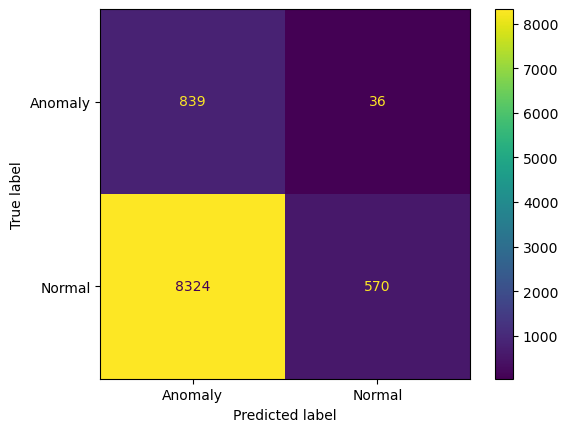

In [5]:

def hybrid_auto_encod_iso_svm():

    # Load data from a CSV file   
    data = pd.read_csv('adultdata.csv')
    
    #convert all the values in the columns into numeric
    label_encoder = LabelEncoder()
    for column in data.select_dtypes(include=['object']).columns:
        data[column] = label_encoder.fit_transform(data[column])
    data.dropna(axis=0, inplace=True)
    
    X = data.drop('Hours_per_week', axis=1)  # This is the target variable
    y_cont = data['Hours_per_week']
    
    y = np.where(y_cont > 20, 1, 0)  # Define `threshold` based on the dataset
    
    # Select top k features; k might be adjusted based on the dataset
    selector = SelectKBest(f_classif, k=5)
    X_selected = selector.fit_transform(X, y)
    
    #data.info()
    
    # Build and train sparse autoencoder
    input_dim = X_selected.shape[1]
    encoding_dim = 32
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
    decoder = Dense(input_dim, activation='sigmoid')(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_selected, X_selected, epochs=50, batch_size=256, shuffle=True)
    
    # Encode the data
    encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
    X_encoded = encoder_model.predict(X_selected)
    
    # Split the data into train and test after encoding
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=5)
    
    # Scale the features after splitting
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Isolation Forest on the encoded data
    iso_forest = IsolationForest(contamination=0.1, n_estimators=100, random_state=5)
    iso_forest.fit(X_train_scaled)
    if_train_labels = iso_forest.predict(X_train_scaled)
    
    # Filter only rows detected as normal
    normal_indices = if_train_labels == 1
    X_train_normal = X_train_scaled[normal_indices]
    y_train_normal = y_train[normal_indices]
    
    
    # Initialize One-Class SVM
    oc_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.05)
    # Fit the model on the training data
    # Note: One-Class SVM is typically trained only on the normal data (label 0)
    oc_svm.fit(X_train_scaled[y_train == 0])
    
    # Predict on the test data
    y_pred = oc_svm.predict(X_test_scaled)
    # Convert predictions to match the original label (1 for normal, -1 for anomaly)
    y_pred = np.where(y_pred == 1, 0, 1)
    
    
    # Evaluate the model
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    
    
    print(classification_report(y_test, y_pred))
    
        # Print metrics
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()
    

hybrid_auto_encod_iso_svm()